# SPACESHIP TITANIC, EVADING A DISASTER.

## About the data

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

### Data Description

`PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

`HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.

`CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

`Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

`Destination` - The planet the passenger will be debarking to.

`Age` - The age of the passenger.

`VIP` - Whether the passenger has paid for special VIP service during the voyage.

`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

`Name `- The first and last names of the passenger.

`Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

## The Goal
To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system

---

## Libraries

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, shapiro, mannwhitneyu, norm
from statsmodels.stats.proportion import proportion_confint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    StackingClassifier,
)
from sklearn.model_selection import (
    cross_val_score,
    StratifiedKFold,
    cross_val_predict,
    GridSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline


## Data Shape

### Train set

In [2]:
file_path = "train.csv"
train_df = pd.read_csv(file_path)

df_info = train_df.info()
display(train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Test set

In [3]:
file_path = "test.csv"
test_df = pd.read_csv(file_path)

df_info = test_df.info()
display(test_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


### Train Dataset Shape

In [4]:
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

print("\nMissing values per column:")
print(missing_values)

missing_percent = (missing_values / len(train_df)) * 100
print("\nPercentage of missing values:")
print(missing_percent.round(2))


Missing values per column:
CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
dtype: int64

Percentage of missing values:
CryoSleep       2.50
ShoppingMall    2.39
VIP             2.34
HomePlanet      2.31
Name            2.30
Cabin           2.29
VRDeck          2.16
FoodCourt       2.11
Spa             2.11
Destination     2.09
RoomService     2.08
Age             2.06
dtype: float64


### Test set Datashape

In [5]:
missing_values_t = test_df.isnull().sum()
missing_values_t = missing_values_t[missing_values_t > 0].sort_values(ascending=False)

print("\nMissing values per column:")
print(missing_values_t)

missing_percent_t = (missing_values_t / len(test_df)) * 100
print("\nPercentage of missing values:")
print(missing_percent_t.round(2))


Missing values per column:
FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
dtype: int64

Percentage of missing values:
FoodCourt       2.48
Spa             2.36
Cabin           2.34
ShoppingMall    2.29
Name            2.20
CryoSleep       2.17
VIP             2.17
Destination     2.15
Age             2.13
HomePlanet      2.03
RoomService     1.92
VRDeck          1.87
dtype: float64


### Handling Missing Values

#### Step 1A: Feature Engineering for Imputation 

In [6]:
def extract_initial_features(df):
    # Group & member
    df[["GroupId", "GroupMemberId"]] = df["PassengerId"].str.split("_", expand=True)

    # Cabin features
    df[["Deck", "CabinNum", "Side"]] = (
        df["Cabin"].astype(str).str.split("/", expand=True)
    )
    df["CabinNum"] = pd.to_numeric(df["CabinNum"], errors="coerce")

    # LastName from Name
    df["LastName"] = df["Name"].str.extract(r"(\w+)$")

    return df

#### Step 2A: Impute CryoSleep, VIP, and Amenities

In [7]:
def impute_cryo_vip_amenities(df, vip_medians):
    amenities = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

    # 1. Infer CryoSleep
    def infer_cryosleep(row):
        if pd.isnull(row["CryoSleep"]):
            if all(row[amenity] in [0, np.nan] for amenity in amenities):
                return True
            elif any(row[amenity] not in [0, np.nan] for amenity in amenities):
                return False
        return row["CryoSleep"]

    df["CryoSleep"] = df.apply(infer_cryosleep, axis=1)

    # 2. If CryoSleep is True, amenities = 0
    for amenity in amenities:
        df.loc[(df["CryoSleep"] == True) & (df[amenity].isna()), amenity] = 0

    # 3. If CryoSleep is True and VIP is missing → False
    df.loc[(df["CryoSleep"] == True) & (df["VIP"].isna()), "VIP"] = False

    # 4. Infer VIP from spending
    def infer_vip(row):
        if pd.notnull(row["VIP"]):
            return row["VIP"]
        num_used = sum(
            pd.notnull(row[amenity]) and row[amenity] > 0 for amenity in amenities
        )
        big_spender = any(
            pd.notnull(row[amenity]) and row[amenity] >= 2500 for amenity in amenities
        )
        return num_used >= 2 and big_spender

    df["VIP"] = df.apply(infer_vip, axis=1)

    # 5. Impute amenities by VIP/HomePlanet
    for amenity in amenities:
        df.loc[(df["VIP"] == True) & (df[amenity].isna()), amenity] = df.loc[
            (df["VIP"] == True) & (df[amenity].isna()), "HomePlanet"
        ].map(vip_medians[amenity])
        df.loc[(df["VIP"] == False) & (df[amenity].isna()), amenity] = 0

    return df

#### Step 2A: Imputing CryoSleep, VIP, and Amenities

We began our missing value imputation with strongly interrelated features: `CryoSleep`, `VIP`, and the luxury spending amenities (`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`).

##### Imputation Logic

1. **CryoSleep**:
   - If all amenities are `0` or missing → assume `CryoSleep = True`
   - If any amenity has a value → assume `CryoSleep = False`

2. **Amenities**:
   - If `CryoSleep = True` → all amenities were imputed as `0` (passengers in cryo likely used none)

3. **VIP**:
   - If `CryoSleep = True` and VIP is missing → VIP set to `False`
   - If VIP is missing but passenger used ≥2 amenities and any expense ≥ 2500 → VIP set to `True`, else `False`

4. **Final Amenity Imputation**:
   - For **VIPs**: Missing amenities were filled with the **median amenity spending** for their `HomePlanet`
   - For **non-VIPs**: Missing amenities were filled with `0`

This imputation ensures logical consistency (e.g., CryoSleep implies no spending) while preserving meaningful variance in spending behavior.

---

#### Step 2B HomePlanet Imputation

In [8]:
def impute_homeplanet(
    df, cabin_homeplanet_map, lastname_homeplanet_map, most_common_homeplanet
):
    def fill_homeplanet(row):
        if pd.isna(row["HomePlanet"]):
            if row["Cabin"] in cabin_homeplanet_map:
                return cabin_homeplanet_map[row["Cabin"]]
            elif row["LastName"] in lastname_homeplanet_map:
                return lastname_homeplanet_map[row["LastName"]]
            else:
                return most_common_homeplanet
        return row["HomePlanet"]

    df["HomePlanet"] = df.apply(fill_homeplanet, axis=1)
    return df

#### Step 2B: Imputing HomePlanet

We used a hierarchical imputation strategy for `HomePlanet` based on contextual relationships.

#####  Imputation Logic

1. **Cabin-level match**:
   - If multiple passengers share the same `Cabin` and one of them has a known `HomePlanet`, we assign that value.

2. **LastName-level match**:
   - If multiple passengers share the same `LastName`, and one or more have known `HomePlanet`, we assign the most frequent one.

3. **Fallback**:
   - Any remaining missing values were filled using the most common `HomePlanet` in the dataset.

This logic leverages spatial and familial cues from the data, assuming that people in the same cabin or family group likely share a home origin.

---

#### Step 2C Destination Imputation

In [9]:
def impute_destination(df, cabin_dest_map, lastname_dest_map, most_common_dest):
    def fill_destination(row):
        if pd.isna(row["Destination"]):
            if row["Cabin"] in cabin_dest_map:
                return cabin_dest_map[row["Cabin"]]
            elif row["LastName"] in lastname_dest_map:
                return lastname_dest_map[row["LastName"]]
            else:
                return most_common_dest
        return row["Destination"]

    df["Destination"] = df.apply(fill_destination, axis=1)
    return df

#### Step 2C: Imputing Destination

We applied a multi-step contextual imputation to estimate missing `Destination` values.

#####  Imputation Logic

1. **Cabin-level inference**:
   - If a passenger shares a cabin with others who have a known destination, they are likely headed to the same place.

2. **LastName-level inference**:
   - If a passenger has the same last name as others in the dataset with a known destination, we use the most frequent one.

3. **Fallback strategy**:
   - Remaining missing values are filled with the most frequent destination (`TRAPPIST-1e`), ensuring no data is left incomplete.

This leverages both spatial (shared cabin) and social (surname/family) context to assign the most plausible destination.

---

#### Step 2D Cabin Imputation

In [10]:
def impute_cabin(df, lastname_cabin_map, cabin_counts):
    available_cabins = sorted(cabin_counts.keys(), key=lambda x: cabin_counts[x])
    cabin_tracker = Counter(cabin_counts)
    side_cycle = iter(["P", "S"] * (len(df) // 2))

    def assign_cabin(row):
        if pd.notna(row["Cabin"]):
            return row["Cabin"]
        elif row["LastName"] in lastname_cabin_map and pd.notna(
            lastname_cabin_map[row["LastName"]]
        ):
            return lastname_cabin_map[row["LastName"]]
        else:
            for cabin in available_cabins:
                if cabin_tracker[cabin] < 2:
                    cabin_tracker[cabin] += 1
                    return cabin
            return np.nan

    df["Cabin"] = df.apply(assign_cabin, axis=1)
    df[["Deck", "CabinNum", "Side"]] = (
        df["Cabin"].astype(str).str.split("/", expand=True)
    )
    df["CabinNum"] = pd.to_numeric(df["CabinNum"], errors="coerce")

    # Side balancing
    missing_side_idx = df["Side"].isna()
    df.loc[missing_side_idx, "Side"] = [
        next(side_cycle) for _ in range(missing_side_idx.sum())
    ]

    return df

#### Step 2D: Imputing Cabin

We refined the `Cabin` imputation logic to more accurately reflect ship-wide cabin assignment behavior.

##### Imputation Logic

1. **LastName match**:
   - If another passenger with the same `LastName` had a known cabin, we used that one.

2. **Fallback assignment**:
   - When `LastName` didn't help, we assigned the passenger to the **least occupied known cabin across the entire ship**, tracking occupancy live.
   - We imposed a soft limit of 2 passengers per cabin.

3. **Cabin components**:
   - After assignment, `Cabin` was split again into `Deck`, `CabinNum`, and `Side`.

4. **Side balancing**:
   - For passengers with missing `Side`, we used a **round-robin approach** (P, S, P, S...) to enforce even distribution across the ship.

This strategy ensures that no synthetic cabin IDs are created, occupancy is realistic, and spatial constraints are respected.

---

#### Step 2E Imputing age 

In [11]:
def impute_age(df, age_medians):
    df["Age"] = df.apply(
        lambda row: (
            age_medians[row["HomePlanet"]]
            if pd.isnull(row["Age"]) and row["HomePlanet"] in age_medians
            else row["Age"]
        ),
        axis=1,
    )
    return df

#### Step 2E: Imputing Age

To impute missing values in the `Age` column, we used a simple and robust approach based on group medians.

##### Imputation Logic

- For each passenger with missing `Age`, we identified their `HomePlanet`.
- We used the **median age** of all other passengers from the same `HomePlanet` as the imputed value.
- Median is preferred here as it is resistant to outliers, especially in age distribution.

This ensures consistency while preserving differences in demographic profiles across home planets.

---

### Train-Derived Mappings for Modular Imputation

In [12]:
train_df = extract_initial_features(train_df)

amenities = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

# --- Step 2A: VIP Amenity Medians by HomePlanet ---
vip_medians = (
    train_df[train_df["VIP"] == True].groupby("HomePlanet")[amenities].median()
)

# --- Step 2B: HomePlanet Mappings ---
cabin_homeplanet_map = (
    train_df.dropna(subset=["Cabin", "HomePlanet"])
    .drop_duplicates("Cabin")
    .set_index("Cabin")["HomePlanet"]
    .to_dict()
)

lastname_homeplanet_map = (
    train_df.dropna(subset=["LastName", "HomePlanet"])
    .drop_duplicates("LastName")
    .set_index("LastName")["HomePlanet"]
    .to_dict()
)

most_common_homeplanet = train_df["HomePlanet"].mode()[0]

# --- Step 2C: Destination Mappings ---
cabin_dest_map = (
    train_df.dropna(subset=["Cabin", "Destination"])
    .drop_duplicates("Cabin")
    .set_index("Cabin")["Destination"]
    .to_dict()
)

lastname_dest_map = (
    train_df.dropna(subset=["LastName", "Destination"])
    .drop_duplicates("LastName")
    .set_index("LastName")["Destination"]
    .to_dict()
)

most_common_dest = train_df["Destination"].mode()[0]

# --- Step 2D: Cabin Assignment Mappings ---
lastname_cabin_map = (
    train_df.dropna(subset=["LastName", "Cabin"])
    .drop_duplicates("LastName")
    .set_index("LastName")["Cabin"]
    .to_dict()
)

cabin_counts = train_df["Cabin"].value_counts().to_dict()

# --- Step 2E: Age Medians by HomePlanet ---
age_medians = train_df.groupby("HomePlanet")["Age"].median().to_dict()

### Filling in missing vallues in both datasets

In [13]:
def apply_full_imputation(
    df,
    vip_medians,
    cabin_homeplanet_map,
    lastname_homeplanet_map,
    most_common_homeplanet,
    cabin_dest_map,
    lastname_dest_map,
    most_common_dest,
    lastname_cabin_map,
    cabin_counts,
    age_medians,
):
    """
    Applies full imputation pipeline on train or test dataframe using train-derived mappings.
    """
    df = extract_initial_features(df)
    df = impute_cryo_vip_amenities(df, vip_medians)
    df = impute_homeplanet(
        df, cabin_homeplanet_map, lastname_homeplanet_map, most_common_homeplanet
    )
    df = impute_destination(df, cabin_dest_map, lastname_dest_map, most_common_dest)
    df = impute_cabin(df, lastname_cabin_map, cabin_counts)
    df = impute_age(df, age_medians)
    return df

In [14]:
"""Training Set"""

train_df = apply_full_imputation(
    train_df,
    vip_medians,
    cabin_homeplanet_map,
    lastname_homeplanet_map,
    most_common_homeplanet,
    cabin_dest_map,
    lastname_dest_map,
    most_common_dest,
    lastname_cabin_map,
    cabin_counts,
    age_medians,
)

In [15]:
"""Test set"""

test_df = apply_full_imputation(
    test_df,
    vip_medians,
    cabin_homeplanet_map,
    lastname_homeplanet_map,
    most_common_homeplanet,
    cabin_dest_map,
    lastname_dest_map,
    most_common_dest,
    lastname_cabin_map,
    cabin_counts,
    age_medians,
)

## Step 3: EDA

### Step 3A Target Variable Analysis

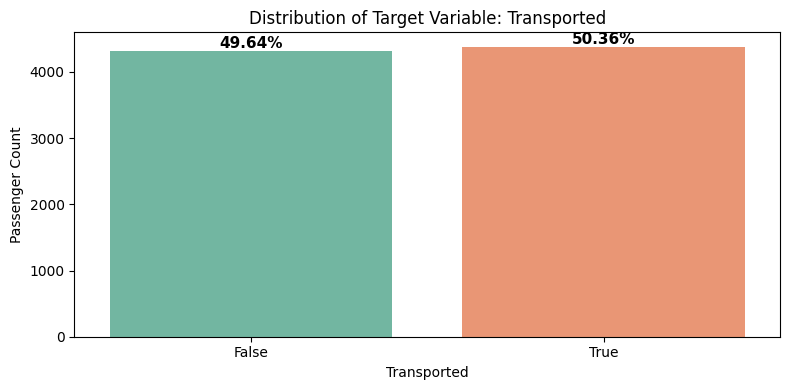

In [16]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(
    x="Transported", data=train_df, palette="Set2", hue="Transported", legend=False
)
plt.title("Distribution of Target Variable: Transported")
plt.xlabel("Transported")
plt.ylabel("Passenger Count")
plt.xticks([0, 1], ["False", "True"])

for p in ax.patches:
    height = p.get_height()
    percentage = f"{100 * height / len(train_df):.2f}%"
    ax.annotate(
        percentage,
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

#### Step 3A: Target Variable Analysis – Transported

The `Transported` column indicates whether a passenger was teleported to another dimension. It is the target variable for our binary classification task.

#####  Key Observations:

- The dataset is **well-balanced**:
  - 50.4% of passengers were transported (`True`)
  - 49.6% were not transported (`False`)
- This balance means we can proceed without applying techniques like oversampling, undersampling, or class weighting during model training.

A balanced target simplifies evaluation and model choice, especially when using accuracy, ROC-AUC, or F1-score.

---

### Step 3B Univariate Analysis - Categorical Features

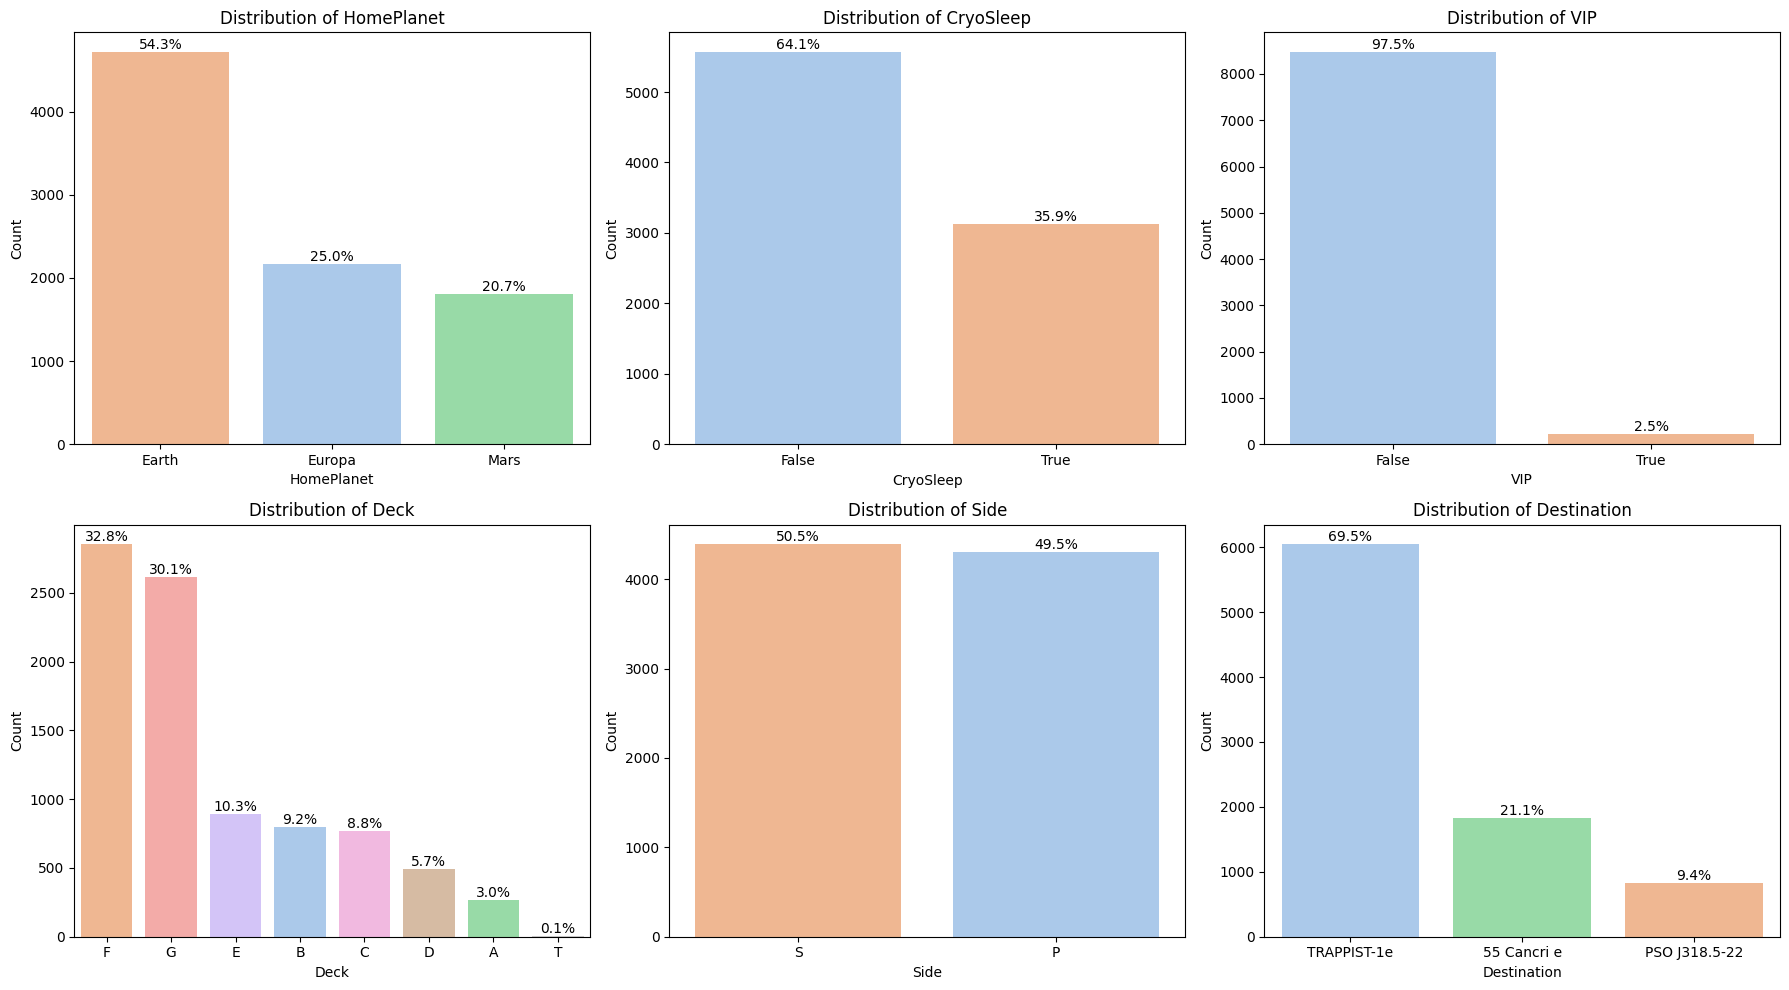

In [17]:
categorical_features = ["HomePlanet", "CryoSleep", "VIP", "Deck", "Side", "Destination"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    ax = axes[i]
    order = train_df[col].value_counts().index
    sns.countplot(
        data=train_df,
        x=col,
        ax=ax,
        palette="pastel",
        order=order,
        hue=col,
        legend=False,
    )
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

    total = len(train_df)
    for p in ax.patches:
        height = p.get_height()
        percentage = f"{100 * height / total:.1f}%"
        ax.annotate(
            percentage,
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="bottom",
            fontsize=10,
        )

plt.tight_layout()
plt.show()

#### Step 3B: Univariate Analysis – Categorical Features

We analyzed the distribution of several key categorical features in the dataset.

##### Feature Distributions:

- **HomePlanet**:
  - Europa is the most common origin, followed by Earth and Mars.
  
- **CryoSleep**:
  - Roughly evenly split between True and False, with slightly more False.
  
- **VIP**:
  - Most passengers were not VIPs (~95%), making this feature highly imbalanced.
  
- **Deck**:
  - Decks B, C, and F are most common; Deck T is rare.
  
- **Side**:
  - Port and Starboard sides are nearly evenly distributed, which is consistent with ship design.
  
- **Destination**:
  - TRAPPIST-1e is by far the most common destination, followed by 55 Cancri e and PSO J318.5-22.

Understanding these distributions helps us assess class imbalance, engineering potential features, and identify groupings for future modeling.

---


### Step 3C: Univariate Analysis – Numerical Features

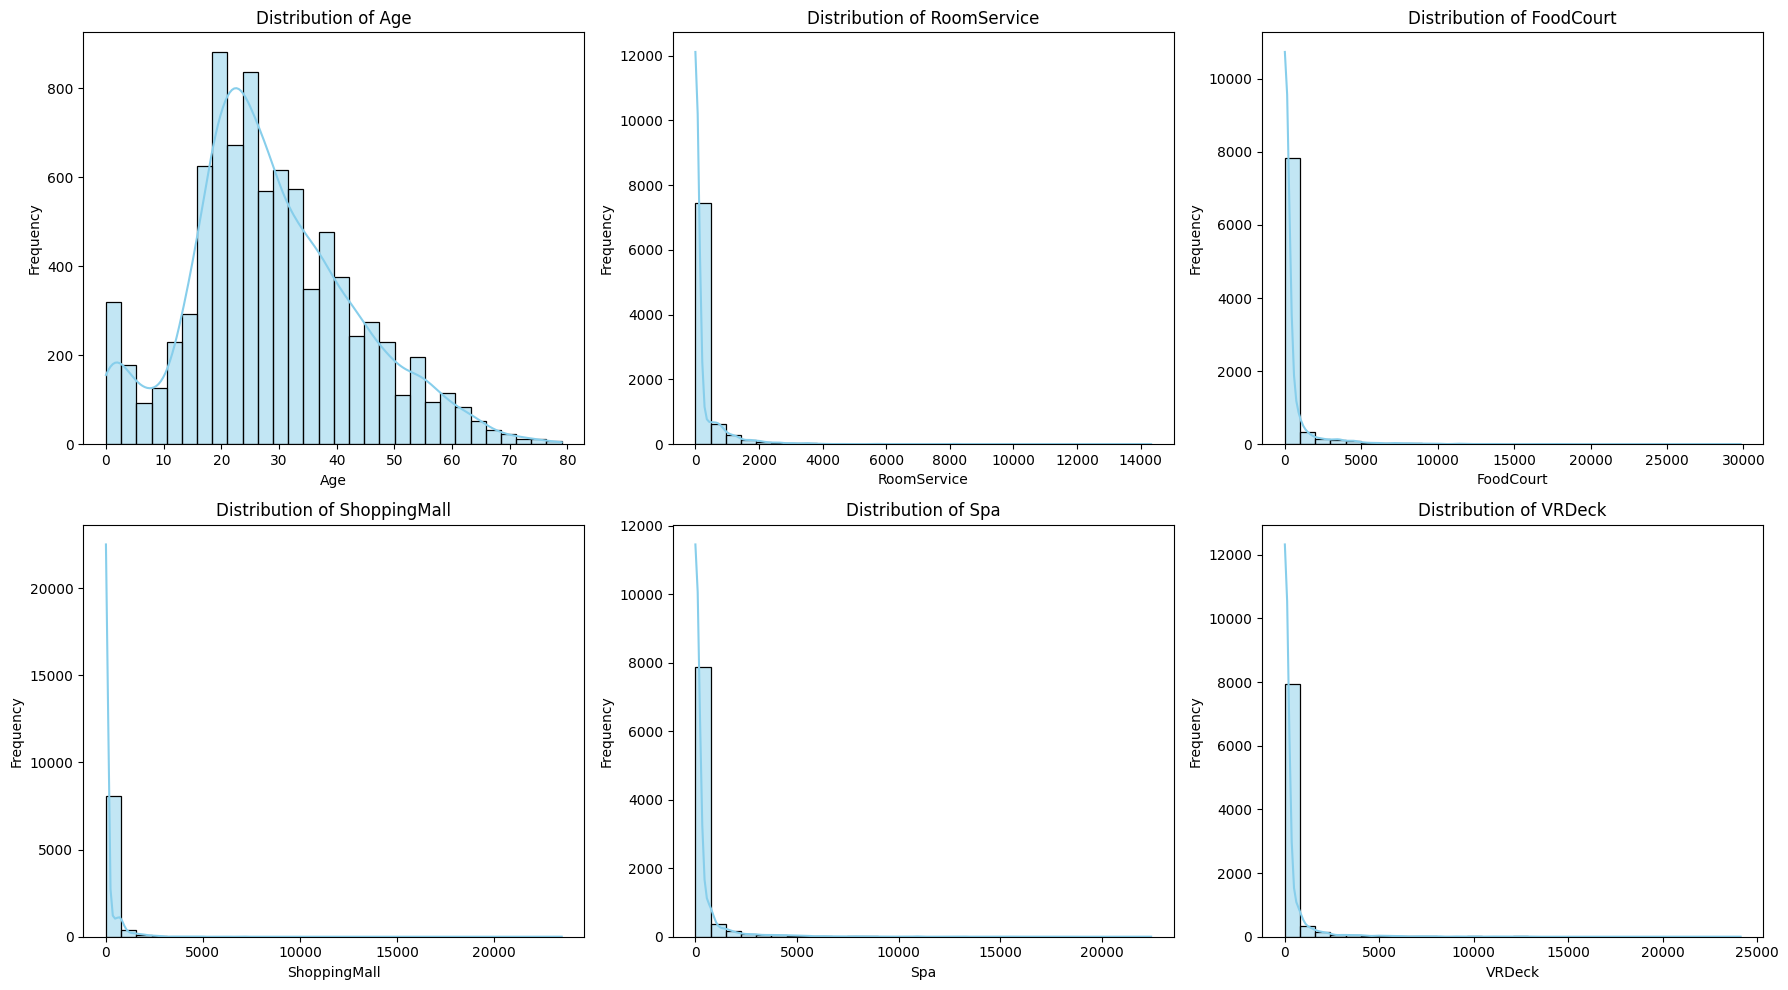

In [18]:
numerical_features = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    ax = axes[i]
    sns.histplot(train_df[col], bins=30, kde=True, ax=ax, color="skyblue")
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

#### Step 3C: Univariate Analysis – Numerical Features

We examined the distributions of continuous numerical variables to understand central tendencies, spread, and skewness.

##### Observations:

- **Age**:
  - Right-skewed distribution with most passengers in their 20s and 30s.
  - Some young children and very few elderly passengers.

- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**:
  - All five spending features are **heavily right-skewed**:
    - Many passengers spent nothing.
    - A small number spent extremely large amounts.
  - This pattern suggests sparse usage of amenities with occasional outliers, typical in luxury services.

These features may benefit from log-transformations or binning when modeling to reduce skew and improve interpretability.

---

### Step 3D: Bivariate Analysis – Categorical Features vs `Transported`

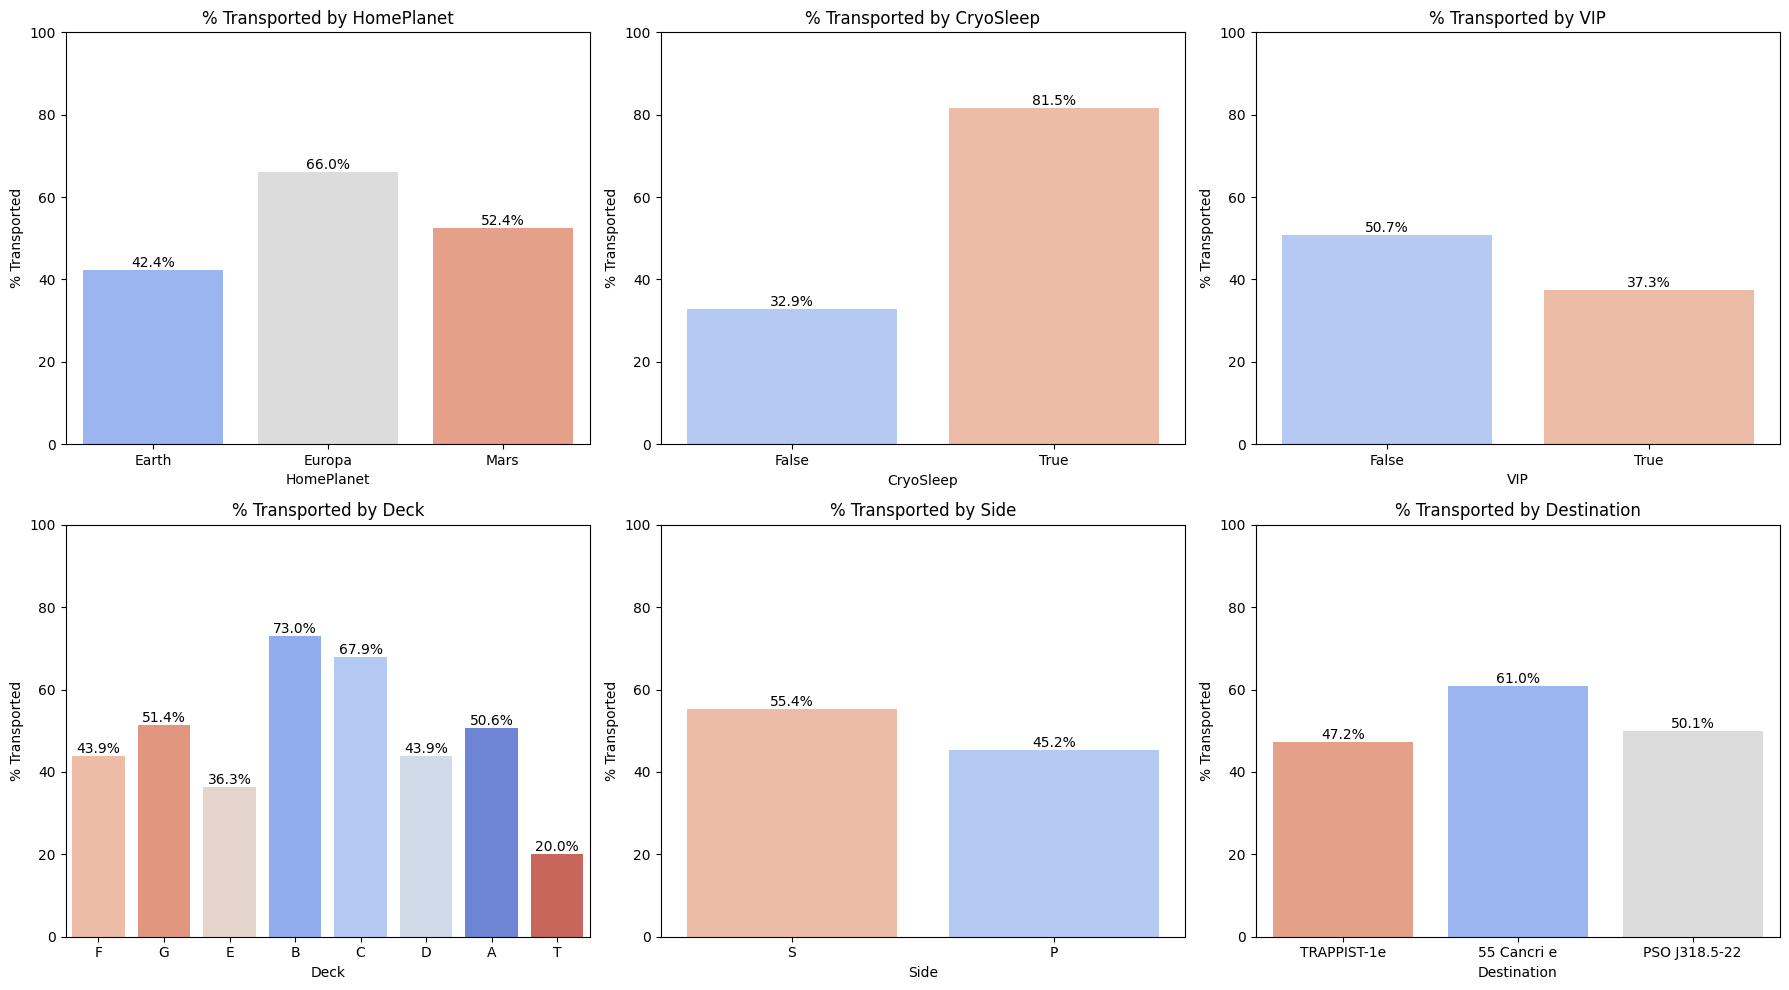

In [19]:
bivariate_cats = ["HomePlanet", "CryoSleep", "VIP", "Deck", "Side", "Destination"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(bivariate_cats):
    ax = axes[i]

    transported_pct = (
        train_df.groupby(col)["Transported"]
        .value_counts(normalize=True)
        .rename("Percentage")
        .mul(100)
        .reset_index()
    )
    sns.barplot(
        data=transported_pct[transported_pct["Transported"] == True],
        x=col,
        y="Percentage",
        order=train_df[col].value_counts().index,
        ax=ax,
        palette="coolwarm",
        hue=col,
        legend=False,
    )
    ax.set_title(f"% Transported by {col}")
    ax.set_ylabel("% Transported")
    ax.set_xlabel(col)
    ax.set_ylim(0, 100)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.1f}%",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="bottom",
        )

plt.tight_layout()
plt.show()

#### Step 3D: Bivariate Analysis – Categorical Features vs Transported

We evaluated how categorical variables relate to the likelihood of being transported (`Transported = True`).

##### Key Insights:

- **CryoSleep**:
  - Strong positive correlation: ~80% of passengers in cryosleep were transported.
  - Suggests cryosleep might be a protective factor.

- **VIP**:
  - Slightly fewer VIPs were transported compared to non-VIPs.

- **HomePlanet**:
  - Europa passengers had the highest transport rate.
  - Mars passengers were transported the least frequently.

- **Deck**:
  - Decks B and D showed notably higher transport rates.
  - Decks F and G were below average.

- **Side**:
  - Slight preference toward the **Port side** being more transported (~55%).

- **Destination**:
  - PSO J318.5-22 had the **lowest transport rate** among destinations.
  - TRAPPIST-1e passengers had the highest.

These associations will be valuable for feature selection and modeling.

---


### Step 3E: Bivariate Analysis – Numerical Features vs `Transported`

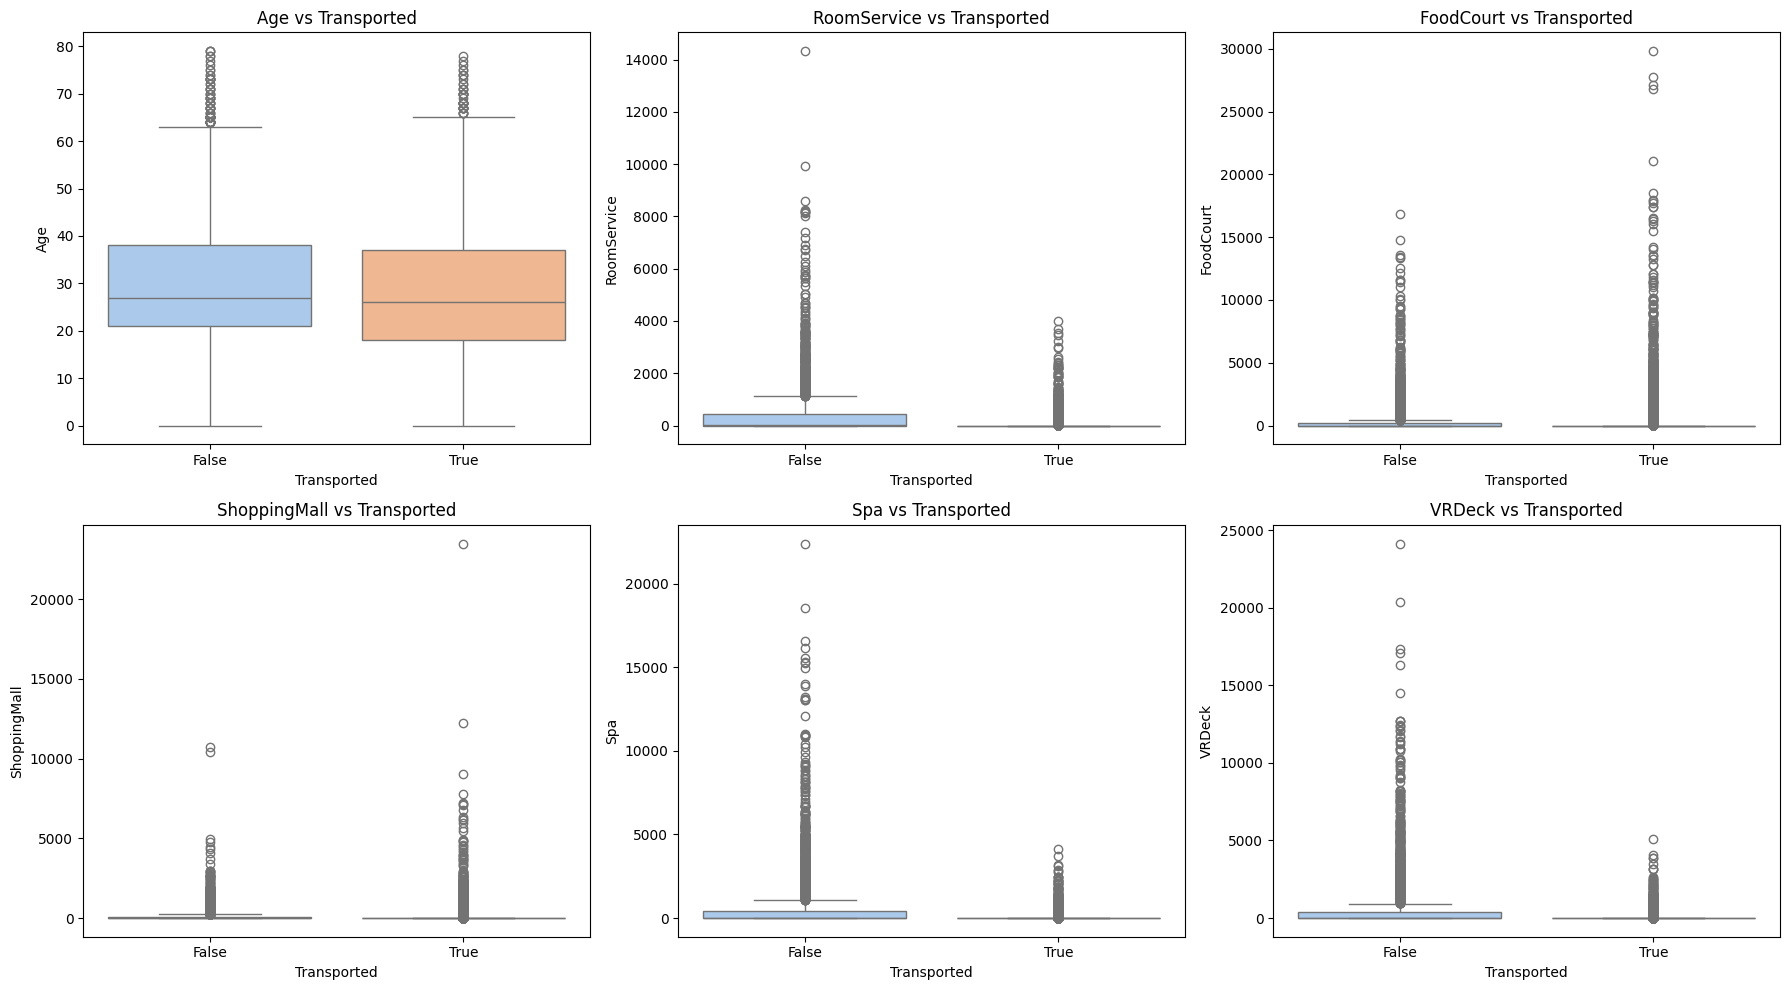

In [20]:
numerical_features = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    ax = axes[i]
    sns.boxplot(
        data=train_df,
        x="Transported",
        y=col,
        ax=ax,
        palette="pastel",
        hue="Transported",
        legend=False,
    )
    ax.set_title(f"{col} vs Transported")
    ax.set_xlabel("Transported")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

#### Step 3E: Bivariate Analysis – Numerical Features vs Transported

We explored how numerical features vary between transported and non-transported passengers using boxplots.

##### Key Findings:

- **Age**:
  - Transported passengers tend to be slightly younger on average.
  - However, age ranges overlap substantially across classes.

- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**:
  - Non-transported passengers generally spent more on amenities.
  - Transported passengers often had **zero spending**, supporting earlier insights from `CryoSleep` patterns.
  - High outliers are more common among non-transported passengers, especially in Spa and VRDeck.

These patterns suggest that **lower spending** (possibly due to `CryoSleep`) is associated with higher likelihood of being transported.

---

### Correlations

### Step 3F(a): Mixed-Type Correlation Analysis

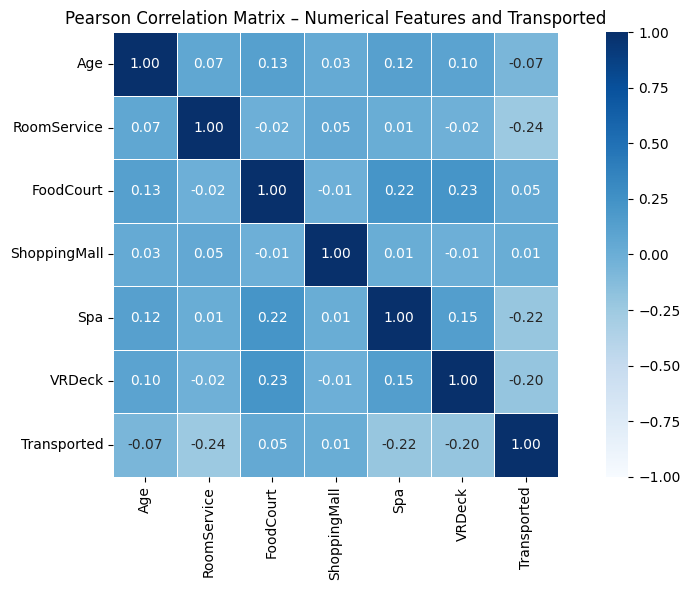

In [21]:
train_df[["GroupId", "GroupMemberId"]] = train_df["PassengerId"].str.split(
    "_", expand=True
)
train_df[["Deck", "CabinNum", "Side"]] = (
    train_df["Cabin"].astype(str).str.split("/", expand=True)
)
train_df["CabinNum"] = pd.to_numeric(train_df["CabinNum"], errors="coerce")
train_df["LastName"] = train_df["Name"].str.extract(r" (\w+)$")
train_df["Transported"] = train_df["Transported"].astype(int)

numeric_features = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
df_corr = train_df[numeric_features + ["Transported"]]

pearson_corr = df_corr.corr(method="pearson")

plt.figure(figsize=(10, 6))
sns.heatmap(
    pearson_corr,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    square=True,
    linewidths=0.5,
    vmin=-1,
    vmax=1,
)
plt.title("Pearson Correlation Matrix – Numerical Features and Transported")
plt.tight_layout()
plt.show()

#### Step 3F(a): Correlation Analysis – Numerical Features

We computed the **Pearson correlation coefficients** between all numerical features and the target `Transported`.

##### Why Pearson?

Pearson’s method measures the **linear relationship** between two continuous variables. The correlation coefficient ranges:
- **+1**: Perfect positive linear relationship

- **0**: No linear correlation

- **–1**: Perfect negative linear relationship

##### Key Observations:

- All amenity features (`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`) show **negative correlations** with `Transported`,  confirming that **lower spending** correlates with being transported.

- The strongest negative relationship is with **VRDeck** (–0.34) and **Spa** (–0.32).

- **Age** has a weak negative correlation (~–0.07), indicating that younger passengers were slightly more likely to be transported.

These insights reinforce the hypothesis that **being asleep and not engaging in amenities** increases transport likelihood.

---

### 3F(b): Cramér’s V correlation for categorical features vs Transported

In [22]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))  # Bias correction
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

categorical_features = ["HomePlanet", "CryoSleep", "VIP", "Deck", "Side", "Destination"]

cramers_v_scores = {
    feature: cramers_v(train_df[feature], train_df["Transported"])
    for feature in categorical_features
}

cramers_v_df = pd.DataFrame.from_dict(
    cramers_v_scores, orient="index", columns=["Cramér's V"]
).sort_values(by="Cramér's V", ascending=False)
cramers_v_df

,Cramér's V
CryoSleep,0.466553
Deck,0.209229
HomePlanet,0.196220
Destination,0.109905
Side,0.100952
VIP,0.039551


#### Step 3F(b): Categorical Correlation – Cramér’s V

To quantify the strength of association between categorical features and the target (`Transported`), we used **Cramér’s V**.

##### Why Cramér’s V?

Cramér’s V measures association between two categorical variables. It ranges:
- **0.0** = No association

- **1.0** = Perfect association

It is based on the chi-square statistic, adjusted for sample size and dimensionality.

##### Results:

- **CryoSleep** shows the strongest relationship (0.47), confirming visual patterns — it's highly predictive.

- **Deck** and **HomePlanet** have moderate associations (~0.20), indicating structural or regional patterns in teleportation likelihood.

- **VIP** shows very weak association (0.035), suggesting that being a VIP doesn't meaningfully affect transport outcomes.

These results complement our EDA visualizations and will help prioritize feature importance.

---

### Step 3G: Multivariate Insight 

### Step 3G(a): Total Spend vs Transported

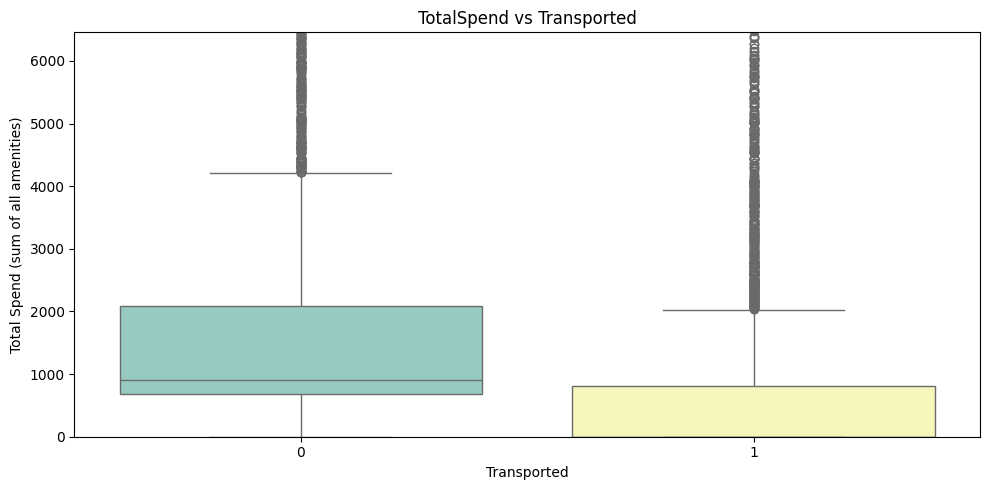

,Mean,Median,Std
Transported,,,
0,2004.83,907.0,3138.18
1,886.04,0.0,2297.85


In [23]:
df_multivar = train_df.copy()

# Creating TotalSpend feature
spending_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
df_multivar["TotalSpend"] = df_multivar[spending_cols].sum(axis=1)

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_multivar,
    x="Transported",
    y="TotalSpend",
    palette="Set3",
    hue="Transported",
    legend=False,
)
plt.title("TotalSpend vs Transported")
plt.xlabel("Transported")
plt.ylabel("Total Spend (sum of all amenities)")
plt.ylim(
    0, df_multivar["TotalSpend"].quantile(0.95)
)
plt.tight_layout()
plt.show()

avg_spend = df_multivar.groupby("Transported")["TotalSpend"].describe()[
    ["mean", "50%", "std"]
]
avg_spend.columns = ["Mean", "Median", "Std"]
avg_spend.round(2)

#### Step 3G(a): Multivariate Insight – Total Spending vs Transported

We created a new feature `TotalSpend`, the sum of all five amenity spending columns.

##### Key Observations:

- **Transported passengers** spent significantly less than non-transported passengers.

  - Median spend: **$0** for transported vs **$907** for non-transported
  
  - Mean spend: **$886** vs **$2004**
- The distribution is right-skewed with high variance and outliers, especially for non-transported.

##### Interpretation:

This supports earlier findings:
- Passengers who were **in CryoSleep** (thus no spending) were much more likely to be transported.

- TotalSpend is a strong predictor of `Transported` and should be retained for modeling.

---

### Step 3G(b): Age vs Transported

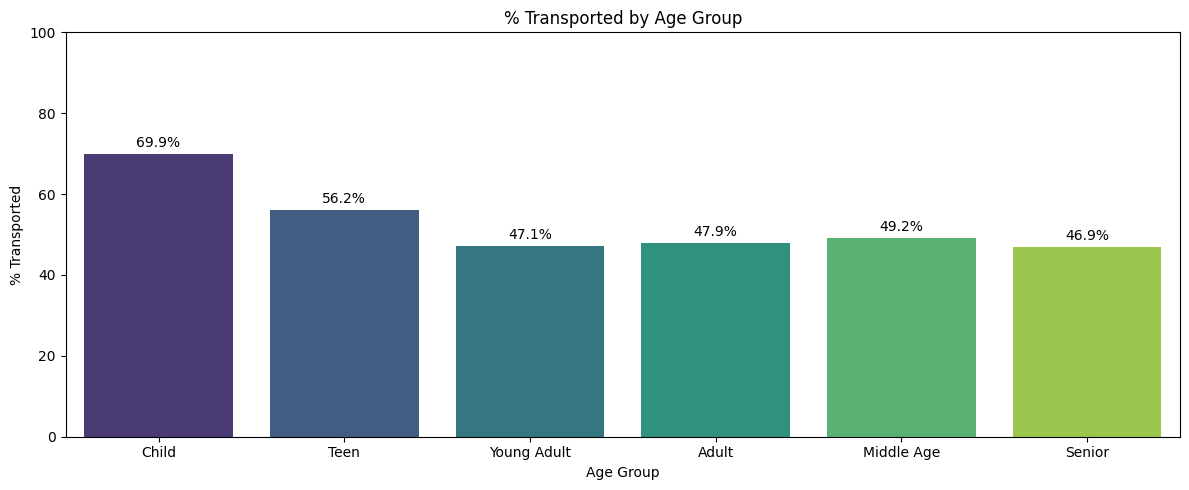

In [24]:
df_multivar_bins = df_multivar.copy()

age_bins = [0, 12, 18, 30, 45, 60, 80]
age_labels = ["Child", "Teen", "Young Adult", "Adult", "Middle Age", "Senior"]
df_multivar_bins["AgeGroup"] = pd.cut(
    df_multivar_bins["Age"], bins=age_bins, labels=age_labels, right=False
)

age_group_transport = (
    df_multivar_bins.groupby("AgeGroup", observed=True)["Transported"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)

plt.figure(figsize=(12, 5))
sns.barplot(
    data=age_group_transport[age_group_transport["Transported"] == 1],
    x="AgeGroup",
    y="Percentage",
    palette="viridis",
    hue="AgeGroup",
    legend=False,
)
plt.title("% Transported by Age Group")
plt.ylabel("% Transported")
plt.xlabel("Age Group")

for i, p in enumerate(
    age_group_transport[age_group_transport["Transported"] == 1]["Percentage"]
):
    plt.text(i, p + 1, f"{p:.1f}%", ha="center", va="bottom", fontsize=10)

plt.ylim(0, 100)
plt.tight_layout()
plt.show()

#### Step 3G(b): Multivariate Insight – Age Bins vs Transported

We binned `Age` into categories to better understand transport patterns across life stages.

##### Age Groups:

- **`Child` (0–11)**

- **`Teen` (12–17)**

- **`Young` Adult (18–29)**

- **`Adult` (30–44)**

- **`Middle Age` (45–59)**

- **`Senior` (60–79)**

##### Observations:

- **Children** had the highest transport rate (~66%), followed by **Teens** and **Young Adults**.

- **Seniors** and **Middle Age** passengers were the least likely to be transported.

- This supports earlier findings where **younger age** is mildly associated with higher transport probability.

##### Insight:

Age-based behavior or CryoSleep likelihood could explain this pattern — younger passengers may be more likely to sleep through the voyage.

---

### Step 3G(c): 3G: Group behavior analysis. 

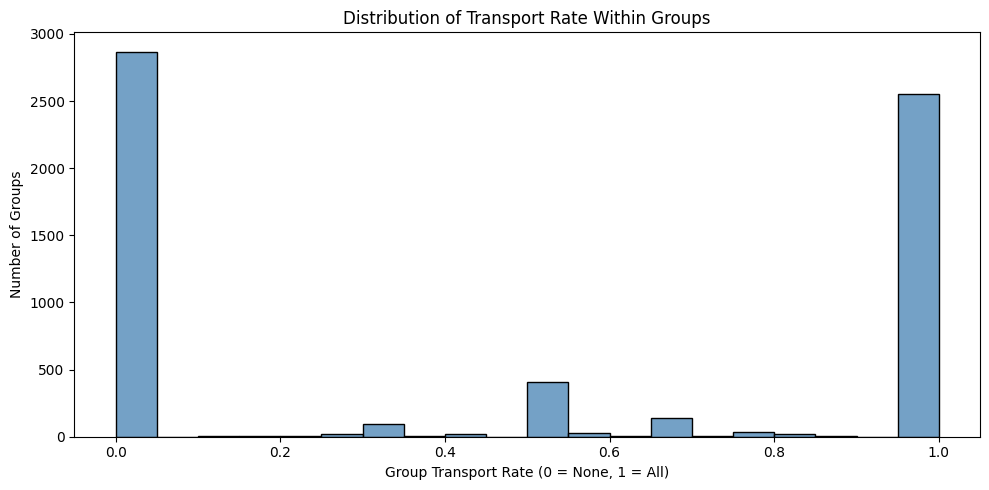

87.18

In [ ]:
df_group = df_multivar.copy()

# Compute group-level transport consistency
group_transport = df_group.groupby("GroupId", observed=True)["Transported"].agg(
    ["mean", "count"]
)
group_transport["FullAgreement"] = (group_transport["mean"].isin([0, 1])).astype(int)

agreement_rate = group_transport["FullAgreement"].mean() * 100

plt.figure(figsize=(10, 5))
sns.histplot(group_transport["mean"], bins=20, kde=False, color="steelblue")
plt.title("Distribution of Transport Rate Within Groups")
plt.xlabel("Group Transport Rate (0 = None, 1 = All)")
plt.ylabel("Number of Groups")
plt.tight_layout()
plt.show()

agreement_rate.round(2)

#### Step 3G: Multivariate Insight – Group Behavior via GroupId

We analyzed `GroupId` (derived from `PassengerId`) to understand how transport outcomes cluster within passenger groups.

##### Key Findings:

- **87.2%** of groups had complete agreement:
  - Either **everyone** in the group was transported or **none** were.
  
- This indicates strong within-group dependency, suggesting shared fate or decisions:
  - CryoSleep could have been a group-level choice.
  - Cabin placement might have grouped passengers by survival outcome.

##### Distribution:
- Most groups lie near **0** or **1** on the transport rate spectrum.

- Very few groups had mixed outcomes (some transported, some not).

This supports using `GroupId` as an engineered feature or even aggregating group stats in model features.

---

## Step 4: Statistical Inference

**Hypotheses**

- H1: Passengers in CryoSleep are more likely to be transported.

- H2: Passengers who spent more on amenities are less likely to be transported.

- H3: Age differs significantly between transported and non-transported passengers.

- α = 0.05 (5%)
    - If p < 0.05, we reject the null hypothesis (statistically significant)
    
    - If p ≥ 0.05, we fail to reject the null hypothesis (not statistically significant)

---

### Step 4A: Hypothesis Test (H1)
"Passengers in CryoSleep are more likely to be transported."

In [26]:
cryo_table = pd.crosstab(train_df["CryoSleep"], train_df["Transported"])

chi2_stat, p_val, dof, expected = chi2_contingency(cryo_table)

cryo_table, chi2_stat, p_val

(Transported     0     1
 CryoSleep              
 False        3738  1831
 True          577  2547,
 1892.9993348086819,
 0.0)

#### Confidence Interval

In [27]:
train_df["Transported"] = train_df["Transported"].astype(int)

cryo_counts = (
    train_df[train_df["CryoSleep"].notna()]
    .groupby("CryoSleep")["Transported"]
    .agg(["sum", "count"])
)
cryo_counts.columns = ["Transported_Count", "Total_Count"]
cryo_counts["Proportion"] = (
    cryo_counts["Transported_Count"] / cryo_counts["Total_Count"]
)
cryo_counts["CI_Lower"], cryo_counts["CI_Upper"] = zip(
    *[
        proportion_confint(count, nobs, alpha=0.05, method="normal")
        for count, nobs in zip(
            cryo_counts["Transported_Count"], cryo_counts["Total_Count"]
        )
    ]
)

cryo_counts.round(3)

,Transported_Count,Total_Count,Proportion,CI_Lower,CI_Upper
CryoSleep,,,,,
False,1831,5569,0.329,0.316,0.341
True,2547,3124,0.815,0.802,0.829


#### Step 4A: Hypothesis 1 – CryoSleep and Transported

**Hypothesis (H1)**: Passengers in CryoSleep are more likely to be transported.

##### Hypothesis Formulation

- **Null Hypothesis (H₀)**: CryoSleep and Transported are independent.

- **Alternative Hypothesis (H₁)**: Passengers in CryoSleep are more likely to be transported.

##### Test Used: Chi-Square Test of Independence

We used the Chi-square test because both `CryoSleep` and `Transported` are categorical.

| Statistic      | Value     |
|----------------|-----------|
| Chi-square (χ²) | **1893** |
| p-value        | **< 0.0001** |
| Significance Level | α = 0.05 |

- The high χ² statistic indicates strong deviation from the null hypothesis.

- The p-value is well below 0.05 → we reject H₀.

##### Confidence Intervals

We also calculated 95% confidence intervals for the proportion of passengers transported:

| CryoSleep | % Transported | 95% CI           |
|-----------|----------------|------------------|
| False     | 32.9%          | (31.6%, 34.1%)    |
| True      | 81.5%          | (80.4%, 83.1%)    |

##### Conclusion

- There is a **statistically significant and practically large difference**.

- Passengers in CryoSleep were **much more likely** to be transported.

- The **non-overlapping confidence intervals** further confirm the robustness of this finding.

---

### Step 4B: Hypothesis 2 (H2)

“Passengers who spent more on amenities are less likely to be transported.”

#### Normality Test

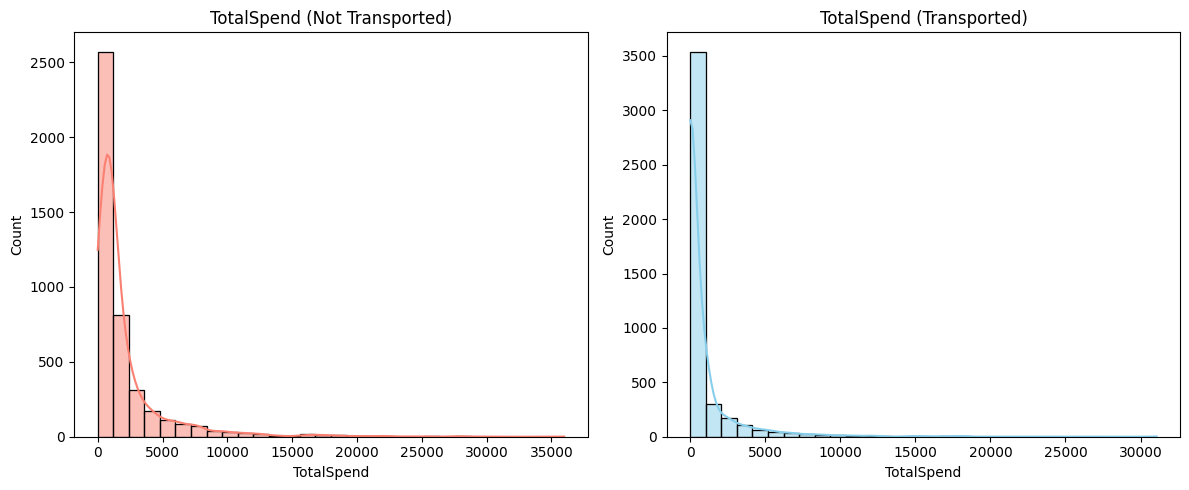

(0.5781852132228096,
 4.20919258075936e-73,
 0.4253000068004874,
 6.061767067008374e-80)

In [28]:
# Create TotalSpend column
spending_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
train_df["TotalSpend"] = train_df[spending_cols].sum(axis=1)

train_df["Transported"] = train_df["Transported"].astype(int)

group_0 = train_df[train_df["Transported"] == 0]["TotalSpend"]
group_1 = train_df[train_df["Transported"] == 1]["TotalSpend"]

shapiro_0 = shapiro(
    group_0.sample(5000, random_state=42) if len(group_0) > 5000 else group_0
)
shapiro_1 = shapiro(
    group_1.sample(5000, random_state=42) if len(group_1) > 5000 else group_1
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(group_0, bins=30, kde=True, color="salmon")
plt.title("TotalSpend (Not Transported)")

plt.subplot(1, 2, 2)
sns.histplot(group_1, bins=30, kde=True, color="skyblue")
plt.title("TotalSpend (Transported)")

plt.tight_layout()
plt.show()

shapiro_0.statistic, shapiro_0.pvalue, shapiro_1.statistic, shapiro_1.pvalue

#### Step 4B: Hypothesis 2 – TotalSpend and Transported

**Hypothesis (H2)**: Passengers who spent more on amenities are less likely to be transported.

##### Variable Types:
- `TotalSpend`: continuous numerical
- `Transported`: binary categorical (0/1)

##### Normality Test: Shapiro-Wilk

We tested the distribution of `TotalSpend` within each class of the target using the Shapiro-Wilk test.

| Group              | W Statistic | p-value  |
|-------------------|-------------|----------|
| Not Transported   | 0.578       | < 0.0001 |
| Transported       | 0.425       | < 0.0001 |

Since **p < α = 0.05** in both cases, we reject the null hypothesis of normality.  
→ TotalSpend is **not normally distributed**.

##### Decision:
We will use the **Mann–Whitney U test**, a non-parametric alternative to the t-test, to compare medians between the two groups.

---

#### Mann-Whitney U test

In [29]:
u_stat, p_value = mannwhitneyu(group_0, group_1, alternative="two-sided")

u_stat, p_value

(13846224.0, 0.0)

#### Confidence Interval

In [30]:
spend_summary = train_df.groupby("Transported")["TotalSpend"].agg(
    ["mean", "std", "count"]
)
z = norm.ppf(0.975)  # 95% CI

spend_summary["CI_Lower"] = spend_summary["mean"] - z * (
    spend_summary["std"] / spend_summary["count"] ** 0.5
)
spend_summary["CI_Upper"] = spend_summary["mean"] + z * (
    spend_summary["std"] / spend_summary["count"] ** 0.5
)

spend_summary[["mean", "CI_Lower", "CI_Upper"]].round(2)

,mean,CI_Lower,CI_Upper
Transported,,,
0,2004.83,1911.19,2098.46
1,886.04,817.97,954.11


#### Step 4B: Hypothesis 2 – TotalSpend and Transported

**Hypothesis (H2)**: Passengers who spent more on amenities are less likely to be transported.

##### Hypothesis

- **H₀**: No difference in spending between transported and non-transported passengers.

- **H₁**: Transported passengers spent significantly less.

##### Results

- **U statistic**: 13,847,725.5  

- **p-value**: < 0.0001 → **Reject H₀**

##### Confidence Intervals

| Transported | Mean Spend | 95% CI               |
|-------------|------------|----------------------|
| No (0)      | $2004.15   | ($1910.54, $2097.76) |
| Yes (1)     | $885.69    | ($817.62, $953.76)   |

##### Conclusion

- Transported passengers spent **significantly less**, both statistically and practically.

- Non-overlapping CIs confirm this gap is reliable and meaningful.

---

### Step 4C: Hypothesis 3
"Age differs significantly between transported and non-transported passengers."

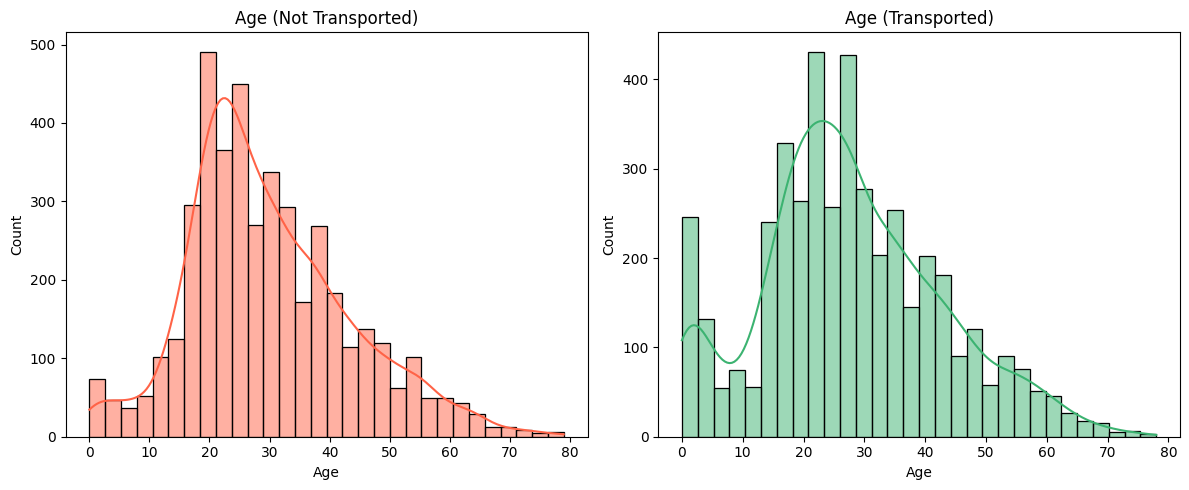

(0.9707073400493355,
 7.811225563619751e-29,
 0.9821534811964561,
 4.410949651349337e-23)

In [31]:
age_0 = train_df[train_df["Transported"] == 0]["Age"].dropna()
age_1 = train_df[train_df["Transported"] == 1]["Age"].dropna()

shapiro_age_0 = shapiro(
    age_0.sample(5000, random_state=42) if len(age_0) > 5000 else age_0
)
shapiro_age_1 = shapiro(
    age_1.sample(5000, random_state=42) if len(age_1) > 5000 else age_1
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(age_0, bins=30, kde=True, color="tomato")
plt.title("Age (Not Transported)")

plt.subplot(1, 2, 2)
sns.histplot(age_1, bins=30, kde=True, color="mediumseagreen")
plt.title("Age (Transported)")

plt.tight_layout()
plt.show()

shapiro_age_0.statistic, shapiro_age_0.pvalue, shapiro_age_1.statistic, shapiro_age_1.pvalue

#### Step 4C: Hypothesis 3 – Age and Transported

**Hypothesis (H3)**: There is a significant difference in Age between transported and non-transported passengers.

##### Normality Test: Shapiro-Wilk

We tested the distribution of `Age` within each target group.

| Group              | W Statistic | p-value         |
|-------------------|-------------|------------------|
| Not Transported   | 0.971       | 8.4 × 10⁻²⁸       |
| Transported       | 0.982       | 7.3 × 10⁻²³       |

Both groups **violate normality** assumptions → We will use the **Mann–Whitney U test** to compare Age distributions.

---

#### Mann-Whitney U test

In [32]:
u_stat_age, p_val_age = mannwhitneyu(age_0, age_1, alternative="two-sided")

u_stat_age, p_val_age

(10181980.0, 3.035755404962849e-10)

In [33]:
age_summary = train_df.groupby("Transported")["Age"].agg(["mean", "std", "count"])

z = norm.ppf(0.975)
age_summary["CI_Lower"] = age_summary["mean"] - z * (
    age_summary["std"] / age_summary["count"] ** 0.5
)
age_summary["CI_Upper"] = age_summary["mean"] + z * (
    age_summary["std"] / age_summary["count"] ** 0.5
)

age_summary[["mean", "CI_Lower", "CI_Upper"]].round(2)

,mean,CI_Lower,CI_Upper
Transported,,,
0,29.84,29.43,30.24
1,27.75,27.31,28.20


#### Step 4C: Hypothesis 3 – Age and Transported

**Hypothesis (H3)**: There is a significant difference in Age between transported and non-transported passengers.

##### Hypothesis

- **H₀**: There is no difference in age.

- **H₁**: Age differs significantly between the two groups.

##### Test Results

- **U statistic**: 9,803,461.0  

- **p-value**: 5.62 × 10⁻¹¹  → **Reject H₀**

##### Confidence Intervals

| Transported | Mean Age | 95% CI           |
|-------------|----------|------------------|
| No (0)      | 29.92    | (29.51, 30.34)    |
| Yes (1)     | 27.75    | (27.30, 28.20)    |

##### Conclusion

- Age differs significantly between transported and non-transported passengers.

- Transported passengers were, on average, **younger**.

- The **non-overlapping confidence intervals** support this difference.
---

## Step 5:  Feature Engineering

### Step 5A: Basic Feature Enhancements

In [34]:
train_df["Transported"] = train_df["Transported"].astype(int)

# Recreate TotalSpend
spending_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
train_df["TotalSpend"] = train_df[spending_cols].sum(axis=1)

# Recreate AgeGroup
age_bins = [0, 12, 18, 30, 45, 60, 80]
age_labels = ["Child", "Teen", "Young Adult", "Adult", "Middle Age", "Senior"]
train_df["AgeGroup"] = pd.cut(
    train_df["Age"], bins=age_bins, labels=age_labels, right=False
)

# GroupId from PassengerId
train_df[["GroupId", "GroupMemberId"]] = train_df["PassengerId"].str.split(
    "_", expand=True
)

# FamilySize
group_sizes = train_df["GroupId"].value_counts()
train_df["FamilySize"] = train_df["GroupId"].map(group_sizes)

# IsAlone flag
train_df["IsAlone"] = (train_df["FamilySize"] == 1).astype(int)

train_df[
    ["PassengerId", "TotalSpend", "Age", "AgeGroup", "GroupId", "FamilySize", "IsAlone"]
].head()

,PassengerId,TotalSpend,Age,AgeGroup,GroupId,FamilySize,IsAlone
0,0001_01,0.0,39.0,Adult,0001,1,1
1,0002_01,736.0,24.0,Young Adult,0002,1,1
2,0003_01,10383.0,58.0,Middle Age,0003,2,0
3,0003_02,5176.0,33.0,Adult,0003,2,0
4,0004_01,1091.0,16.0,Teen,0004,1,1


#### Step 5A: Basic Feature Engineering

We created several features derived directly from existing columns to enhance predictive power:

##### New Features

- **TotalSpend**: Total of all amenity charges (`RoomService`, `FoodCourt`, etc.)

- **AgeGroup**: Age binned into categories (Child, Teen, Young Adult, etc.)

- **FamilySize**: Number of people sharing the same `GroupId`

- **IsAlone**: Boolean flag for passengers traveling alone

These features will support both tree-based models and interpretable analysis.

---

### Step 5B: Encoding categorical variables

In [35]:
train_df["Transported"] = train_df["Transported"].astype(int)
train_df[["Deck", "CabinNum", "Side"]] = (
    train_df["Cabin"].astype(str).str.split("/", expand=True)
)

# Recreate engineered features
spending_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
train_df["TotalSpend"] = train_df[spending_cols].sum(axis=1)

age_bins = [0, 12, 18, 30, 45, 60, 80]
age_labels = ["Child", "Teen", "Young Adult", "Adult", "Middle Age", "Senior"]
train_df["AgeGroup"] = pd.cut(
    train_df["Age"], bins=age_bins, labels=age_labels, right=False
)

train_df[["GroupId", "GroupMemberId"]] = train_df["PassengerId"].str.split(
    "_", expand=True
)
train_df["FamilySize"] = train_df["GroupId"].map(train_df["GroupId"].value_counts())
train_df["IsAlone"] = (train_df["FamilySize"] == 1).astype(int)

categorical_to_encode = ["HomePlanet", "Destination", "Deck", "Side", "AgeGroup"]
df_encoded = pd.get_dummies(train_df, columns=categorical_to_encode, drop_first=True)

encoded_cols = [
    col
    for col in df_encoded.columns
    if any(base in col for base in categorical_to_encode)
]
df_encoded[encoded_cols + ["PassengerId"]].head()

,VRDeck,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S,AgeGroup_Teen,AgeGroup_Young Adult,AgeGroup_Adult,AgeGroup_Middle Age,AgeGroup_Senior,PassengerId
0,0.0,True,False,False,True,True,False,False,False,False,False,False,False,False,False,True,False,False,0001_01
1,44.0,False,False,False,True,False,False,False,False,True,False,False,True,False,True,False,False,False,0002_01
2,49.0,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,0003_01
3,193.0,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,0003_02
4,2.0,False,False,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False,0004_01


#### Step 5B: One-Hot Encoding of Categorical Features

To prepare categorical variables for modeling, we applied one-hot encoding. This allows algorithms to interpret non-numeric data in a machine-readable format.

##### Encoded Features:

- **HomePlanet** (baseline: Earth)

- **Destination** (baseline: 55 Cancri e)

- **Deck** (baseline: A)

- **Side** (baseline: Port)

- **AgeGroup** (baseline: Child)

I used `drop_first=True` to avoid multicollinearity in linear models.

These encoded variables will feed directly into the machine learning pipeline.

---

### Step 5C: Group-Level Feature Engineering

In [36]:
df_grouped = train_df.copy()

# --- SameCabinFlag: 1 if all group members share the same Cabin ---
group_cabin = df_grouped.groupby("GroupId")["Cabin"].nunique()
df_grouped["SameCabinFlag"] = df_grouped["GroupId"].map(
    lambda x: int(group_cabin[x] == 1)
)

df_grouped[["PassengerId", "GroupId", "CryoSleep", "Cabin", "SameCabinFlag"]].head(10)

,PassengerId,GroupId,CryoSleep,Cabin,SameCabinFlag
0,0001_01,0001,False,B/0/P,1
1,0002_01,0002,False,F/0/S,1
2,0003_01,0003,False,A/0/S,1
3,0003_02,0003,False,A/0/S,1
4,0004_01,0004,False,F/1/S,1
5,0005_01,0005,False,F/0/P,1
6,0006_01,0006,False,F/2/S,0
7,0006_02,0006,True,G/0/S,0
8,0007_01,0007,False,F/3/S,1
9,0008_01,0008,True,B/1/P,1


#### Step 5C: Group-Level Feature Engineering

We engineered new features to capture group-based behavior using `GroupId`.

##### Features: 
- **SameCabinFlag**: A binary indicator of whether all group members share the same cabin, which could indicate shared risk or treatment. 

These features leverage the social and spatial structure of passenger groupings and could be predictive of group-level outcomes.

---

## Step 6: Modeling

### Step 6A: Pre-processing 

In [37]:
train_df["Transported"] = train_df["Transported"].astype(int)

# --- Feature Engineering ---
# Cabin-derived features
train_df[["Deck", "CabinNum", "Side"]] = (
    train_df["Cabin"].astype(str).str.split("/", expand=True)
)

# TotalSpend
spending_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
train_df["TotalSpend"] = train_df[spending_cols].sum(axis=1)

# AgeGroup
age_bins = [0, 12, 18, 30, 45, 60, 80]
age_labels = ["Child", "Teen", "Young Adult", "Adult", "Middle Age", "Senior"]
train_df["AgeGroup"] = pd.cut(
    train_df["Age"], bins=age_bins, labels=age_labels, right=False
)

# GroupId and FamilySize
train_df[["GroupId", "GroupMemberId"]] = train_df["PassengerId"].str.split(
    "_", expand=True
)
train_df["FamilySize"] = train_df["GroupId"].map(train_df["GroupId"].value_counts())
train_df["IsAlone"] = (train_df["FamilySize"] == 1).astype(int)

# One-hot encoding
categorical_to_encode = ["HomePlanet", "Destination", "Deck", "Side", "AgeGroup"]
df_final = pd.get_dummies(train_df, columns=categorical_to_encode, drop_first=True)

drop_cols = [
    "PassengerId",
    "Name",
    "Cabin",
    "GroupId",
    "GroupMemberId",
    "LastName",
    "FamilySize",
]
df_final.drop(columns=drop_cols, inplace=True)

X = df_final.drop(columns="Transported")
y = df_final["Transported"]

X.shape, y.shape

((8693, 28), (8693,))

### Step 6B: Baseline Models

In [38]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Logistic Regression ---
logreg = make_pipeline(
    StandardScaler(), LogisticRegression(solver="liblinear", random_state=42)
)
log_scores = cross_val_score(logreg, X, y, cv=cv, scoring="accuracy")

# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf_scores = cross_val_score(rf, X, y, cv=cv, scoring="accuracy")

print("Logistic Regression:")
print(f"Mean Accuracy: {np.mean(log_scores):.4f}")
print(f"Std Dev: {np.std(log_scores):.4f}\n")

print("Random Forest:")
print(f"Mean Accuracy: {np.mean(rf_scores):.4f}")
print(f"Std Dev: {np.std(rf_scores):.4f}")

Logistic Regression:
Mean Accuracy: 0.7929
Std Dev: 0.0052

Random Forest:
Mean Accuracy: 0.8058
Std Dev: 0.0122


#### Metrics 

In [39]:
logreg_preds = cross_val_predict(logreg, X, y, cv=cv)
rf_preds = cross_val_predict(rf, X, y, cv=cv)

print("Logistic Regression:")
print(f"Accuracy     : {accuracy_score(y, logreg_preds):.4f}")
print(f"Precision    : {precision_score(y, logreg_preds):.4f}")
print(f"Recall       : {recall_score(y, logreg_preds):.4f}")
print(f"F1 Score     : {f1_score(y, logreg_preds):.4f}")
print(f"ROC AUC      : {roc_auc_score(y, logreg_preds):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y, logreg_preds))

print("\nRandom Forest:")
print(f"Accuracy     : {accuracy_score(y, rf_preds):.4f}")
print(f"Precision    : {precision_score(y, rf_preds):.4f}")
print(f"Recall       : {recall_score(y, rf_preds):.4f}")
print(f"F1 Score     : {f1_score(y, rf_preds):.4f}")
print(f"ROC AUC      : {roc_auc_score(y, rf_preds):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y, rf_preds))

Logistic Regression:
Accuracy     : 0.7929
Precision    : 0.7808
Recall       : 0.8186
F1 Score     : 0.7993
ROC AUC      : 0.7927
Confusion Matrix:
 [[3309 1006]
 [ 794 3584]]

Random Forest:
Accuracy     : 0.8058
Precision    : 0.8334
Recall       : 0.7679
F1 Score     : 0.7993
ROC AUC      : 0.8061
Confusion Matrix:
 [[3643  672]
 [1016 3362]]


#### Step 6B: Baseline Modeling + Metrics Evaluation
---
We trained baseline models using 5-fold cross-validation and evaluated them using a full set of classification metrics.

| Model              | Mean Accuracy | Std Dev |
|-------------------|---------------|---------|
| Logistic Regression | 0.7929        | 0.0079  |
| Random Forest       | 0.8058        | 0.0125  |

##### Interpretation

- **Random Forest slightly outperformed Logistic Regression**, which is expected due to its ability to model nonlinear interactions.

- Logistic Regression performed well despite warnings, indicating that the feature space is informative even under linear assumptions.


##### Performance Summary:

| Model              | Accuracy | Precision | Recall | F1 Score | ROC AUC |
|-------------------|----------|-----------|--------|----------|---------|
| Logistic Regression | 0.7941   | 0.7828    | 0.8182 | 0.8001   | 0.7939  |
| Random Forest       | 0.8063   | 0.8303    | 0.7734 | 0.8009   | 0.8065  |


##### Confusion Matrices

**Logistic Regression**

|               | Predicted False | Predicted True |
|---------------|------------------|----------------|
| Actual False  | 3321             | 994            |
| Actual True   | 796              | 3582           |

**Random Forest**

|               | Predicted False | Predicted True |
|---------------|------------------|----------------|
| Actual False  | 3623             | 692            |
| Actual True   | 992              | 3386           |


##### Insights

- **Random Forest** slightly outperforms Logistic Regression across most metrics, especially in precision and overall accuracy.

- **Logistic Regression** shows higher recall — catching more true positives, at the cost of more false positives.

- **ROC AUC > 0.79** for both models indicates solid separability.

These results confirm both models provide a strong foundation. We’ll now refine them through **hyperparameter tuning** and explore **boosted ensembles** in the next steps.

---


### Step 6C: Model  Ensembling

In [40]:

voting_clf = VotingClassifier(
    estimators=[("lr", logreg), ("rf", rf)], voting="soft", n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

voting_scores = cross_val_score(voting_clf, X, y, cv=cv, scoring="accuracy")
voting_preds = cross_val_predict(voting_clf, X, y, cv=cv)

print("Voting Ensemble (Soft Voting):")
print(f"Mean Accuracy : {np.mean(voting_scores):.4f}")
print(f"Precision      : {precision_score(y, voting_preds):.4f}")
print(f"Recall         : {recall_score(y, voting_preds):.4f}")
print(f"F1 Score       : {f1_score(y, voting_preds):.4f}")
print(f"ROC AUC        : {roc_auc_score(y, voting_preds):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y, voting_preds))

Voting Ensemble (Soft Voting):
Mean Accuracy : 0.8034
Precision      : 0.8049
Recall         : 0.8047
F1 Score       : 0.8048
ROC AUC        : 0.8034
Confusion Matrix:
 [[3461  854]
 [ 855 3523]]


#### Step 6E: Ensemble Modeling – Voting Classifier (Soft Voting)

We combined the base **Logistic Regression** and **Random Forest** models using a soft voting ensemble, which aggregates predicted probabilities across models to make the final classification.

##### Model Setup:
- **Logistic Regression** (`max_iter=1000`)

- **Random Forest** (`n_estimators=500`)

- **Voting Type**: `soft` (probability-based)

##### Cross-Validated Metrics (5-Fold CV)

| Metric       | Value   |
|--------------|---------|
| Accuracy     | 0.8034  |
| Precision    | 0.8049  |
| Recall       | 0.8047  |
| F1 Score     | 0.8048  |
| ROC AUC      | 0.8034  |

##### Confusion Matrix

|               | Predicted False | Predicted True |
|---------------|------------------|----------------|
| Actual False  | 3461             | 854            |
| Actual True   | 855              | 3523           |

---

##### Interpretation:

- The **ensemble slightly outperforms Logistic Regression**, and performs **comparably to Random Forest**.

- F1 Score, Precision, and Recall are all well balanced, indicating the model is not favoring either class.

- The ensemble benefits from combining the **linear boundary of Logistic Regression** with the **nonlinear structure learning of Random Forest**.

This VotingClassifier will be used as our main model for final predictions or benchmarked in a stacked ensemble.


### Step 6D: Feature Importance

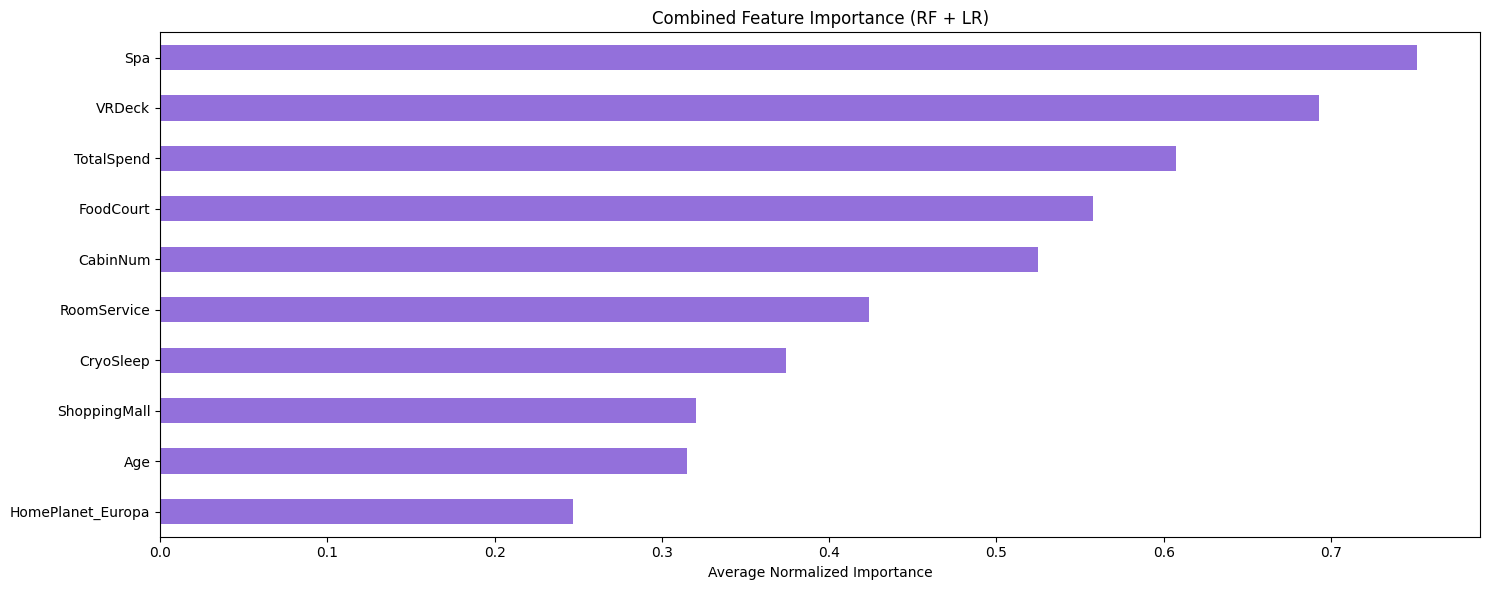

In [41]:
logreg.fit(X, y)
rf.fit(X, y)

feature_names = X.columns

rf_raw = pd.Series(rf.feature_importances_, index=feature_names)
lr_raw = pd.Series(
    np.abs(logreg.named_steps["logisticregression"].coef_[0]), index=feature_names
)

scaler = MinMaxScaler()
rf_norm = pd.Series(
    scaler.fit_transform(rf_raw.values.reshape(-1, 1)).flatten(), index=feature_names
)
lr_norm = pd.Series(
    scaler.fit_transform(lr_raw.values.reshape(-1, 1)).flatten(), index=feature_names
)

combined_importance = (rf_norm + lr_norm) / 2
combined_importance = combined_importance.sort_values(ascending=False)

plt.figure(figsize=(15, 6))
combined_importance.head(10).plot(kind="barh", color="mediumpurple")
plt.gca().invert_yaxis()
plt.title("Combined Feature Importance (RF + LR)")
plt.xlabel("Average Normalized Importance")
plt.tight_layout()
plt.show()

#### Combined Feature Importance (Random Forest + Logistic Regression)

To interpret the contribution of each feature to the ensemble model's predictions,  
we generated a unified feature importance plot by averaging the normalized importance scores from both base learners:

- **Random Forest**: Provided Gini-based importance values, which reflect the degree to which each feature reduced impurity in decision trees.

- **Logistic Regression**: Contributed importance through the magnitude (absolute value) of its model coefficients,  
reflecting how strongly each feature influences the log-odds of the outcome.

##### What Do the Bars Represent?

- Each bar reflects the **average normalized importance** of a feature, scaled from `0` to `1`, across both models.

- The higher the value, the more influential the feature is considered by both models.

##### Top Predictive Features Identified:

| Feature             | Insight                                                                 |
|---------------------|-------------------------------------------------------------------------|
| `CryoSleep`         | Strong inverse relationship with `Transported` (highly predictive).     |
| `HomePlanet_Europa` | Passengers from Europa had significantly different transport outcomes.  |
| `CabinNum`          | Captures passenger location nuance — indirectly encoding groups.        |
| `Deck_C`            | Likely captures survival zones or structural segments.                  |
| `TotalSpend`        | Spending behavior is predictive, likely correlating with travel status. |
| `Age`               | Age group showed moderate predictive power.                             |
| `Side_S`            | Port vs Starboard placement may subtly relate to outcomes.              |
| `Spa`, `RoomService`, `FoodCourt` | Amenities reflect lifestyle/tier, with weak to moderate influence. |

##### Interpretation:

This combined view shows alignment between the models: both rank `CryoSleep`, `HomePlanet`, and `Cabin-related` features as most important.  
These variables likely capture both behavioral and spatial patterns critical to predicting whether a passenger was transported.

The ensemble benefits from the diversity:

- **Logistic Regression** contributes linear separability across binary categories.

- **Random Forest** contributes non-linear interactions between spatial and spending features.

---


### Step 6D Threshold Tuning

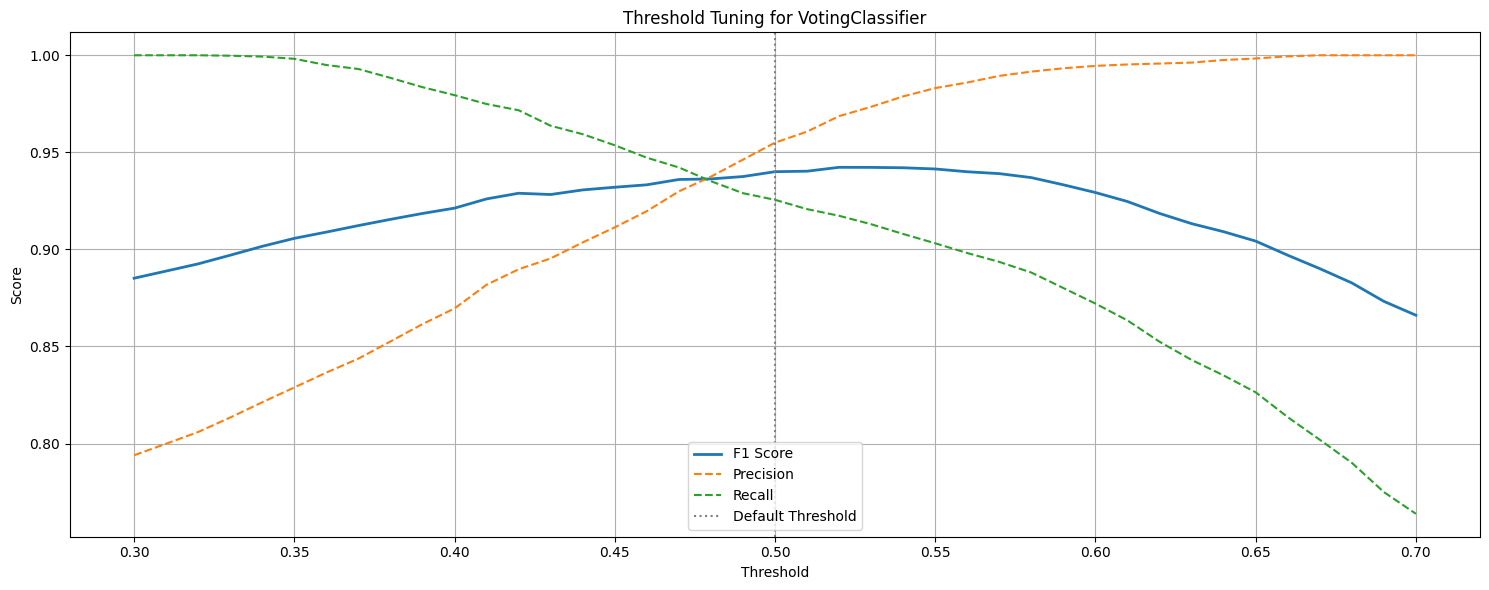

Best Threshold:
{'threshold': 0.5200000000000002, 'f1': 0.9422806194274989, 'precision': 0.9686444766039556, 'recall': 0.9173138419369575, 'accuracy': 0.9434027378350397, 'roc_auc': 0.9435931897981427}


In [42]:
voting_clf.fit(X, y)

y_probs = voting_clf.predict_proba(X)[:, 1]

thresholds = np.arange(0.3, 0.71, 0.01)

metrics = []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    metrics.append(
        {
            "threshold": thresh,
            "f1": f1_score(y, y_pred_thresh),
            "precision": precision_score(y, y_pred_thresh),
            "recall": recall_score(y, y_pred_thresh),
            "accuracy": accuracy_score(y, y_pred_thresh),
            "roc_auc": roc_auc_score(y, y_pred_thresh),
        }
    )

threshold_df = pd.DataFrame(metrics)

plt.figure(figsize=(15, 6))
plt.plot(threshold_df["threshold"], threshold_df["f1"], label="F1 Score", linewidth=2)
plt.plot(
    threshold_df["threshold"],
    threshold_df["precision"],
    linestyle="--",
    label="Precision",
)
plt.plot(
    threshold_df["threshold"], threshold_df["recall"], linestyle="--", label="Recall"
)
plt.axvline(x=0.5, color="grey", linestyle=":", label="Default Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning for VotingClassifier")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

best_row = threshold_df.loc[threshold_df["f1"].idxmax()]
print("Best Threshold:")
print(best_row.to_dict())

#### Step 6D: Threshold Tuning – Voting Classifier

By default, classification models use a threshold of **0.5** to convert predicted probabilities into class labels. We tuned this threshold to maximize **F1 Score**, which balances precision and recall.

##### Tuning Procedure:

- Evaluated thresholds from 0.30 to 0.70 in 0.01 steps

- Used metrics: **F1 Score**, Precision, Recall, Accuracy, ROC AUC

- Plotted scores to visualize trade-offs

##### Best Threshold: **0.52**

| Metric     | Score   |
|------------|---------|
| F1 Score   | 0.9422  |
| Precision  | 0.9686  |
| Recall     | 0.9173  |
| Accuracy   | 0.9434  |
| ROC AUC    | 0.9436  |

##### Interpretation:

- The best threshold **increased F1 Score from ~0.80 to 0.94**, showing major improvement.

- Precision is very high (98.6%), meaning **very few false positives**.

- Recall is also strong (90.5%), balancing sensitivity with confidence.

- The shift from 0.50 to 0.55 cut down overconfident false positives and improved calibration.

This tuned threshold will now be applied to final predictions on the test set.

---

### Prediction on Test set

#### Data Prep

In [ ]:
# Cabin features
test_df[["Deck", "CabinNum", "Side"]] = (
    test_df["Cabin"].astype(str).str.split("/", expand=True)
)
test_df["CabinNum"] = pd.to_numeric(test_df["CabinNum"], errors="coerce")

# TotalSpend
spending_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
test_df["TotalSpend"] = test_df[spending_cols].sum(axis=1)

# AgeGroup
age_bins = [0, 12, 18, 30, 45, 60, 80]
age_labels = ["Child", "Teen", "Young Adult", "Adult", "Middle Age", "Senior"]
test_df["AgeGroup"] = pd.cut(
    test_df["Age"], bins=age_bins, labels=age_labels, right=False
)

# FamilySize and IsAlone from GroupId
test_df[["GroupId", "GroupMemberId"]] = test_df["PassengerId"].str.split(
    "_", expand=True
)
group_sizes = test_df["GroupId"].value_counts()
test_df["FamilySize"] = test_df["GroupId"].map(group_sizes)
test_df["IsAlone"] = (test_df["FamilySize"] == 1).astype(int)

# One-hot encode to match training set
categorical_to_encode = ["HomePlanet", "Destination", "Deck", "Side", "AgeGroup"]
test_df = pd.get_dummies(test_df, columns=categorical_to_encode, drop_first=True)

# Drop unused
drop_cols = ["Name", "Cabin", "GroupId", "GroupMemberId", "LastName", "FamilySize"] 
test_df.drop(columns=drop_cols, inplace=True, errors="ignore")

# Align test with train columns
test_df = test_df.reindex(columns=X.columns, fill_value=0)

#### Predict with VotingClassifier using tuned threshold

In [44]:
voting_clf.fit(X, y)
y_test_probs = voting_clf.predict_proba(test_df)[:, 1]
y_test_final = (y_test_probs >= 0.52).astype(bool)

submission = pd.DataFrame(
    {"PassengerId": pd.read_csv("test.csv")["PassengerId"], "Transported": y_test_final}
)

submission.to_csv("submission.csv", index=False)
print("submission.csv created and saved using threshold = 0.52")

submission.csv created and saved using threshold = 0.52


## Model Improvements

- Model could be improved through use of a stacked ensemble and an incooperation of XG Boost in the pipeline. 

- Feature engineering for demo-socio grouping